**MLP : метод обратного распространения ошибки**

два обрабатывающих слоя

Евгений Борисов borisov.e@solarl.ru

---

In [29]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [30]:
# # загружаем даные
# c1 = np.loadtxt('data/200_2b/points_1.txt')
# c2 = np.loadtxt('data/200_2b/points_2.txt')

In [31]:
# загружаем даные
c1 = np.vstack([
    np.loadtxt('data/399_4/points_b.txt'),
    np.loadtxt('data/399_4/points_g.txt'),
    np.loadtxt('data/399_4/points_r.txt')
])

c2 = np.loadtxt('data/399_4/points_y.txt')


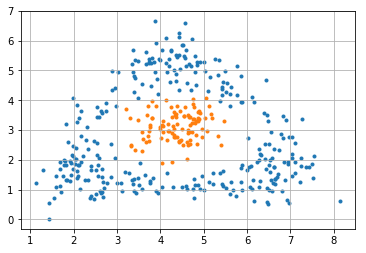

In [32]:
plt.scatter(c1[:,0],c1[:,1],marker='.')
plt.scatter(c2[:,0],c2[:,1],marker='.')
plt.grid()
plt.show()

In [33]:
# собираем вместе
X = np.vstack([c1,c2])
X.shape

(399, 2)

In [34]:
# метки классов
Y = np.array( [-1,1]*c1.shape[0] + 
              [1,-1]*c2.shape[0], 
            ).reshape( c1.shape[0] + c2.shape[0], 2 ) 
Y.shape

(399, 2)

In [35]:
# нормируем данные
scaler = MinMaxScaler([-1.0,1.0])
scaler.fit(X)
X = scaler.transform(X)

X.min(), X.max()

(-1.0, 1.0)

---

In [36]:
# инициализация генератора псевдослучайных чисел
np.random.seed(seed= int((time.time() % 1)*1e7) )

In [37]:
X, X_test, Y, Y_test = train_test_split( X, Y, test_size=0.5 ) # , random_state=int((time.time() % 1)*1e7) )
X, X_val, Y, Y_val = train_test_split( X, Y, test_size=0.3) #, random_state=int((time.time() % 1)*1e7) )
# X_val, Y_val = X, Y

---

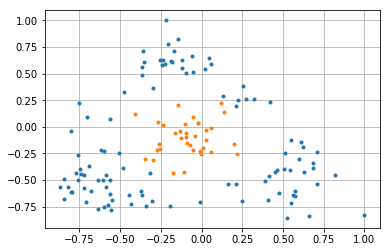

In [38]:
# учебный
r=np.argmax(Y,axis=1).astype(bool)
X1 = X[ r, : ]
X2 = X[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

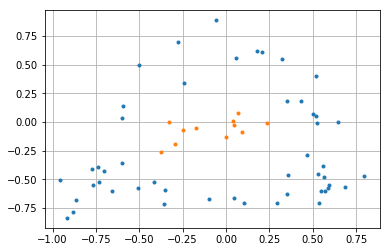

In [39]:
# контрольный
r=np.argmax(Y_val,axis=1).astype(bool)
X1 = X_val[ r, : ]
X2 = X_val[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

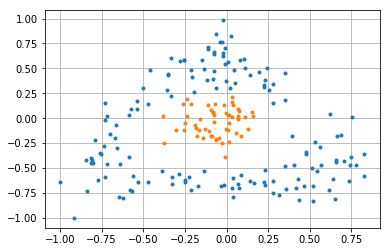

In [40]:
# тестовый
r=np.argmax(Y_test,axis=1).astype(bool)
X1 = X_test[ r, : ]
X2 = X_test[ ~r,: ]
fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()

---

In [41]:
# ф-ция активации слоёв
def act(z): return np.tanh(z)

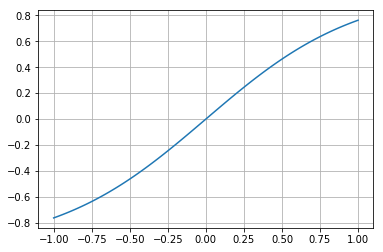

In [42]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act(jj) )
plt.grid()
plt.show()

In [43]:
# производная ф-ции активации слоёв
def act_drv(z): return 1.0/(np.cosh(z)**2)

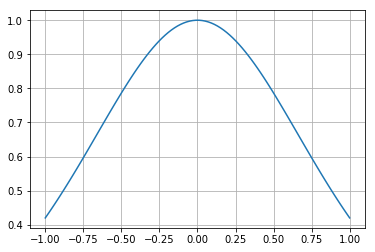

In [44]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act_drv(jj) )
plt.grid()
plt.show()

In [45]:
# размер скрытого слоя
s_layer = 10

In [46]:
# инициализация весов и сдвигов
# W0 = ( np.random.rand( X.shape[1], s_layer ) - 0.5 ) * 0.01
W0 = np.random.normal(loc=0.0, scale=0.1, size=[X.shape[1], s_layer])
S0 = np.zeros(s_layer)

#W1 = ( np.random.rand( s_layer,Y.shape[1] ) - 0.5 ) * 0.01
W1 = np.random.normal(loc=0.0, scale=0.1, size=[s_layer,Y.shape[1] ])
S1 = np.zeros(Y.shape[1])

---

In [47]:
# выход
def run(x): 
    return act( act( x.dot(W0) + S0 ).dot(W1) + S1 ) # выход сети


In [48]:
# прямой проход
def forward(x):
    L = [ x.dot(W0) + S0 ] # состояние (не активированное) скрытого слоя
    L.append( act(L[0]).dot(W1) + S1   ) # состояние (не активированное) выходного слоя
    return L


In [49]:
# обратный проход
def backward(L):
    O = act(L[1]) # выход сети
    E = [ (O-Y)*act_drv(L[1]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W1.T)*act_drv(L[0]) ) # ошибка скрытого слоя
    return E


In [50]:
# градиент
def grad(L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O = act(L[0]) # выход скрытого слоя
    GW.append( O.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS


In [51]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), gw[1].flatten(), gs[0], gs[1], ])).max()
        
    if mw != 0.0:
        gw[0] /= mw
        gw[1] /= mw
        gs[0] /= mw
        gs[1] /= mw
    
    return gw,gs


In [52]:
def msqe(o,y):
    e = (o-y).flatten() # ошибки примеров
    e = np.asscalar( e.T.dot(e) )*(1.0/y.shape[0])  # средняя квадратичная ошибка
    assert ~np.isnan(e), 'ошибка вычислений'
    return e

In [25]:
# метод градиентного спуска

a=0.01 # скорость обучения
r=0.001 # регуляризация
m=0.001 # момент

# ex_count = X.shape[0]   # количество примеров

# максимальное число циклов обучения
MAX_ITER = 800

MIN_ERROR = 0.25 # порог минимальной ошибки

err =[1e7] 

dW1=dW0=dS0=dS1=0.0

for i in range(MAX_ITER):
    O = run(X_val) # выход сети
    err.append( msqe(O,Y_val) ) # история значений ф-ции потери
    
    if err[-1] < MIN_ERROR: # проверяем достижение порога
        break

    L=forward(X) # прямой проход
    E=backward(L) # обратный проход
    GW,GS = grad(L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент
    
    
    dW0 = a*( GW[0]+ r*W0 ) + m*dW0
    dW1 = a*( GW[1]+ r*W1 ) + m*dW1
    dS0 = a*GS[0]+ m*dS0
    dS1 = a*GS[1]+ m*dS1
    
    # изменяем веса и сдвиги
    W0 -= dW0
    W1 -= dW1 
    S0 -= dS0
    S1 -= dS1

print('step:',i,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)
   

step: 697 / 800
error: 0.24961625806296742 / 0.25


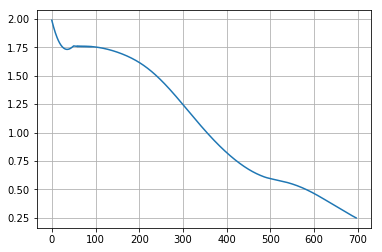

In [26]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[2:])
plt.grid()
plt.show()

---

0.25927449609321196


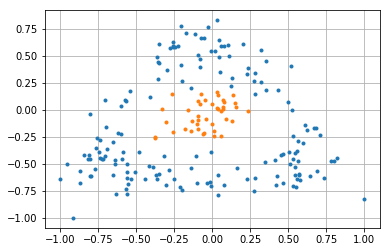

In [28]:
# результат

O = run(X_test)
print(msqe(O,Y_test))
r=np.argmax(O,axis=1).astype(bool)

X1 = X_test[ r, : ]
X2 = X_test[ ~r,: ]

fig, ax = plt.subplots()
ax.plot(X1[:,0],X1[:,1],'.')
ax.plot(X2[:,0],X2[:,1],'.')
plt.grid()
plt.show()